## 图片风格迁移和GAN

![](images4/1.png)

![](images4/2.png)

损失函数：
![](images4/5.png)

内容损失：
i:channel, j:把长宽压扁后的feature vector
![](images4/3.png)

第一个和 第二个 指的是l层特征图flatten好的向量。理解：假设图片经过某层卷积层后得到了[height, width, channel]的特征图，为了进行Gram matrix的操作，需要将特征图进行flatten，得到 F=[height``*``width, channel] 的特征图，那么这里的G=F.transpose* F, 得到size为[channel, channel]的G矩阵，表达特征图里面的自相关。

风格损失：
代表生成图和风格图经过卷积层得到的特征图、然后自相关得到的Gram matrix。一样用平方误差作为损失函数来使两者接近。

![](images4/4.png)

In [1]:
from __future__ import division
%matplotlib inline
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

读取两张图片


In [2]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

content = load_image("png/content.png", transform, max_size=400)
style = load_image("png/style.png", transform, shape=[content.size(2), content.size(3)])


In [3]:
content.shape

torch.Size([1, 3, 300, 400])

In [4]:
style.shape

torch.Size([1, 3, 400, 300])

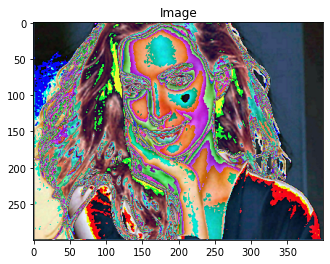

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(content[0], title='Image')
# content.shape

In [6]:
vgg = models.vgg19(pretrained=True)

In [7]:
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [8]:
# 特征提取器
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28']
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [9]:
vgg = VGGNet().to(device).eval()

In [10]:
features = vgg(content)

In [11]:
for feat in features:
    print(feat.shape)

torch.Size([1, 64, 300, 400])
torch.Size([1, 128, 150, 200])
torch.Size([1, 256, 75, 100])
torch.Size([1, 512, 37, 50])
torch.Size([1, 512, 18, 25])


In [12]:
# target是和content一样的内容，是要训练的
# target是一个tensor，直接传一个tensor默认是不训练
target = content.clone().requires_grad_(True)
# 不断训练target，使得内容像content但是风格像另外一张图片
optimizer = torch.optim.Adam([target], lr=0.003, betas=[0.5, 0.999]) 
    

开始优化target图片

In [13]:
total_step = 2000

for step in range(total_step):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    content_loss = style_loss = 0.
    # 计算loss
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        content_loss += torch.mean((f1-f2)**2)
        
        # 计算style_loss需要做点积，但是feature是多维，所以把feature压扁
        _, c, h, w = f1.size()
        f1 = f1.view(c, h*w)
        f3 = f3.view(c, h*w)
        
        f1 = torch.mm(f1, f1.t())
        f3 = torch.mm(f3, f3.t())
        style_loss += torch.mean((f1-f3)**2) / (c*h*w)
        
    loss = content_loss + style_loss * 100.
    
    # 更新target image的tensor
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        print("Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
             .format(step, total_step, content_loss.item(), style_loss.item()))
        
        
        

Step [0/2000], Content Loss: 0.0000, Style Loss: 88.4290
Step [100/2000], Content Loss: 11.4831, Style Loss: 30.5124
Step [200/2000], Content Loss: 13.6139, Style Loss: 21.9088
Step [300/2000], Content Loss: 14.7924, Style Loss: 16.9885
Step [400/2000], Content Loss: 15.6142, Style Loss: 13.7791
Step [500/2000], Content Loss: 16.2530, Style Loss: 11.5272
Step [600/2000], Content Loss: 16.7468, Style Loss: 9.8932
Step [700/2000], Content Loss: 17.1695, Style Loss: 8.6655
Step [800/2000], Content Loss: 17.5312, Style Loss: 7.7168
Step [900/2000], Content Loss: 17.8181, Style Loss: 6.9671
Step [1000/2000], Content Loss: 18.1085, Style Loss: 6.3565
Step [1100/2000], Content Loss: 18.3038, Style Loss: 5.8514
Step [1200/2000], Content Loss: 18.5611, Style Loss: 5.4422
Step [1300/2000], Content Loss: 18.7825, Style Loss: 5.0572
Step [1400/2000], Content Loss: 18.8731, Style Loss: 4.7623
Step [1500/2000], Content Loss: 19.0894, Style Loss: 4.4754
Step [1600/2000], Content Loss: 19.2934, Style 

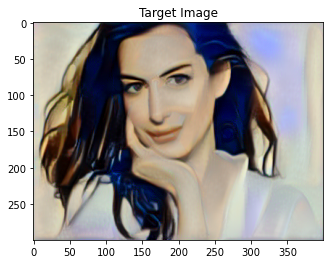

In [14]:
denorm = transforms.Normalize([-2.12, -2.04, -1.80], [4.37, 4.46, 4.44])
img = target.clone().squeeze()
img = denorm(img).clamp_(0, 1)
imshow(img, title = "Target Image") 

## Generative Adversarial Networks

基本思路：要定义两个模型

- Generator：生成器，目标是让生成的数据接近真实数据
- Discriminator：分类器，目标是能够鉴别真实数据和生成的假数据

![](images4/6.png)

In [15]:
batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,
                        std=0.5)
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

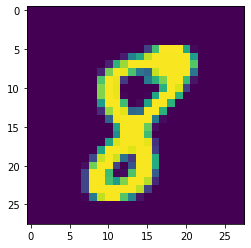

In [16]:
plt.imshow(next(iter(dataloader))[0][10][0])

In [17]:
image_size = 28 * 28
hidden_size = 256

# 判别器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64
# 生成器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh() # -1, 1
)

D = D.to(device)
G = G.to(device)

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)




训练模型

In [18]:

total_step = len(dataloader)
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.shape[0]
        images = images.reshape(batch_size, image_size).to(device)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images)
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs # 对于D来说，越大越好
        
        # 开始生成fake images
        z = torch.randn(batch_size, latent_size).to(device) # latent variable
        fake_images = G(z)
        outputs = D(fake_images.detach()) # 节点脱离
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs # 对于D来说，越小越好
        
        # 开始优化discriminiator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 开始优化generator
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels) #希望生成的图片接近1
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print("Epoc [{}/{}], Step [{}/{}], d_loss:{:.4f}, g_loss:{:.4f}, D(x):{:.2f}, D(G(z)):{:.2f}"
                 .format(epoch, num_epochs, i, total_step, d_loss.item(), g_loss.item(), 
                         real_score.mean().item(),fake_score.mean().item()))
            

Epoc [0/30], Step [0/1875], d_loss:1.4188, g_loss:0.7002, D(x):0.48, D(G(z)):0.50
Epoc [0/30], Step [200/1875], d_loss:0.0794, g_loss:4.4641, D(x):0.97, D(G(z)):0.04
Epoc [0/30], Step [400/1875], d_loss:0.1601, g_loss:4.6967, D(x):0.97, D(G(z)):0.07
Epoc [0/30], Step [600/1875], d_loss:0.0519, g_loss:5.4125, D(x):0.97, D(G(z)):0.02
Epoc [0/30], Step [800/1875], d_loss:0.0582, g_loss:6.5215, D(x):0.97, D(G(z)):0.03
Epoc [0/30], Step [1000/1875], d_loss:0.0304, g_loss:4.0745, D(x):1.00, D(G(z)):0.03
Epoc [0/30], Step [1200/1875], d_loss:0.4409, g_loss:3.7163, D(x):0.95, D(G(z)):0.29
Epoc [0/30], Step [1400/1875], d_loss:0.2552, g_loss:2.7342, D(x):0.91, D(G(z)):0.08
Epoc [0/30], Step [1600/1875], d_loss:0.9696, g_loss:1.7343, D(x):0.85, D(G(z)):0.49
Epoc [0/30], Step [1800/1875], d_loss:0.5051, g_loss:4.0541, D(x):0.79, D(G(z)):0.07
Epoc [1/30], Step [0/1875], d_loss:0.6396, g_loss:2.6340, D(x):0.76, D(G(z)):0.13
Epoc [1/30], Step [200/1875], d_loss:0.8221, g_loss:1.5407, D(x):0.84, D(G(

Epoc [9/30], Step [1600/1875], d_loss:0.5854, g_loss:2.9347, D(x):0.89, D(G(z)):0.28
Epoc [9/30], Step [1800/1875], d_loss:0.4312, g_loss:3.5192, D(x):0.82, D(G(z)):0.08
Epoc [10/30], Step [0/1875], d_loss:0.5916, g_loss:2.3249, D(x):0.85, D(G(z)):0.18
Epoc [10/30], Step [200/1875], d_loss:0.4320, g_loss:3.7071, D(x):0.85, D(G(z)):0.08
Epoc [10/30], Step [400/1875], d_loss:0.3138, g_loss:4.7211, D(x):0.92, D(G(z)):0.09
Epoc [10/30], Step [600/1875], d_loss:0.5296, g_loss:3.0879, D(x):0.84, D(G(z)):0.15
Epoc [10/30], Step [800/1875], d_loss:0.4974, g_loss:3.7419, D(x):0.80, D(G(z)):0.10
Epoc [10/30], Step [1000/1875], d_loss:0.5288, g_loss:2.2920, D(x):0.91, D(G(z)):0.28
Epoc [10/30], Step [1200/1875], d_loss:0.4269, g_loss:3.2015, D(x):0.94, D(G(z)):0.25
Epoc [10/30], Step [1400/1875], d_loss:0.3523, g_loss:4.0809, D(x):0.82, D(G(z)):0.05
Epoc [10/30], Step [1600/1875], d_loss:0.5082, g_loss:2.4839, D(x):0.82, D(G(z)):0.14
Epoc [10/30], Step [1800/1875], d_loss:0.4661, g_loss:2.8898, D

Epoc [19/30], Step [1000/1875], d_loss:0.8262, g_loss:1.6029, D(x):0.81, D(G(z)):0.34
Epoc [19/30], Step [1200/1875], d_loss:0.6487, g_loss:2.0484, D(x):0.74, D(G(z)):0.18
Epoc [19/30], Step [1400/1875], d_loss:0.7621, g_loss:1.6719, D(x):0.77, D(G(z)):0.26
Epoc [19/30], Step [1600/1875], d_loss:0.7307, g_loss:1.7125, D(x):0.86, D(G(z)):0.30
Epoc [19/30], Step [1800/1875], d_loss:0.8667, g_loss:2.4522, D(x):0.60, D(G(z)):0.09
Epoc [20/30], Step [0/1875], d_loss:0.5035, g_loss:2.5165, D(x):0.78, D(G(z)):0.14
Epoc [20/30], Step [200/1875], d_loss:0.6456, g_loss:1.6178, D(x):0.81, D(G(z)):0.24
Epoc [20/30], Step [400/1875], d_loss:0.4969, g_loss:2.1050, D(x):0.85, D(G(z)):0.23
Epoc [20/30], Step [600/1875], d_loss:0.7247, g_loss:1.5744, D(x):0.88, D(G(z)):0.35
Epoc [20/30], Step [800/1875], d_loss:0.6841, g_loss:2.1839, D(x):0.75, D(G(z)):0.22
Epoc [20/30], Step [1000/1875], d_loss:0.8178, g_loss:2.3843, D(x):0.68, D(G(z)):0.20
Epoc [20/30], Step [1200/1875], d_loss:1.0364, g_loss:3.7801,

Epoc [29/30], Step [400/1875], d_loss:0.8379, g_loss:1.7175, D(x):0.82, D(G(z)):0.32
Epoc [29/30], Step [600/1875], d_loss:0.5491, g_loss:2.1472, D(x):0.83, D(G(z)):0.22
Epoc [29/30], Step [800/1875], d_loss:0.7760, g_loss:1.1270, D(x):0.77, D(G(z)):0.33
Epoc [29/30], Step [1000/1875], d_loss:0.8024, g_loss:1.3978, D(x):0.81, D(G(z)):0.34
Epoc [29/30], Step [1200/1875], d_loss:0.4731, g_loss:2.3351, D(x):0.82, D(G(z)):0.18
Epoc [29/30], Step [1400/1875], d_loss:0.9279, g_loss:1.9762, D(x):0.61, D(G(z)):0.23
Epoc [29/30], Step [1600/1875], d_loss:0.7018, g_loss:2.1259, D(x):0.68, D(G(z)):0.15
Epoc [29/30], Step [1800/1875], d_loss:0.8245, g_loss:2.2687, D(x):0.61, D(G(z)):0.10


fake images

In [19]:
z = torch.randn(batch_size, latent_size).to(device) # latent variable
fake_images = G(z)


In [20]:
fake_images = fake_images.view(batch_size, 28, 28).data.cpu().numpy()

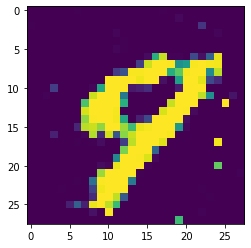

In [26]:
plt.imshow(fake_images[5])

### DCGAN

In [27]:
import torchvision.utils as vutils